In [1]:
import warnings
import copy
import numpy as np
import pandas as pd
from sqlalchemy import text
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
import plotly.express as px
import scikitplot as skplt
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC  
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_curve
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import functools as ft
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, auc, confusion_matrix, accuracy_score
sns.set_palette('RdBu_r')

In [2]:
df = pd.read_csv('Churn_data.csv')
df.head()

,CustomerID,Geography,Gender,Age_Band,TenureYears,EstimatedIncome,BalanceEuros,NoProducts,CreditCardholder,CustomerWithLoan,Digital_TRX_ratio,Active
0,5188208,Rest_GR,Male,18-25,0,40683.96,50086.2120,1,0,0,0.38,0
1,8683784,Thessaloniki,Female,65+,4,2429.51,0.0000,1,1,0,0.33,1
2,3512360,Athens,Male,45-55,4,41694.49,26852.7072,1,1,1,0.72,0
3,7104818,Rest_GR,Male,25-35,5,74523.33,90325.6200,1,0,0,0.08,0
4,6712745,Rest_GR,Female,25-35,9,111050.49,100537.0608,2,0,0,1.38,0


# Data Preparation

In [3]:
# Base statistics
df.describe()

,CustomerID,TenureYears,EstimatedIncome,BalanceEuros,NoProducts,CreditCardholder,CustomerWithLoan,Digital_TRX_ratio,Active
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5.056704e+06,5.012800,88078.508767,50480.686930,1.530200,0.70550,0.515100,0.696598,0.204200
std,2.868552e+06,2.892174,50034.128696,41182.287434,0.581654,0.45584,0.499797,0.199715,0.403136
min,5.080000e+02,0.000000,1010.070000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000
25%,2.596564e+06,3.000000,45371.835000,0.000000,1.000000,0.00000,0.000000,0.560000,0.000000
50%,5.040021e+06,5.000000,88168.705000,64151.036400,1.000000,1.00000,1.000000,0.700000,0.000000
75%,7.521026e+06,7.000000,130967.772500,84245.198400,2.000000,1.00000,1.000000,0.830000,0.000000
max,9.999654e+06,10.000000,174993.460000,165592.739400,4.000000,1.00000,1.000000,1.420000,1.000000


In [4]:
# Let's check for dublicate customer ids in the dataset first
# It seems there are 7 customer ids with more than one entries
df[df.duplicated('CustomerID', keep=False) == True].sort_values('CustomerID')

,CustomerID,Geography,Gender,Age_Band,TenureYears,EstimatedIncome,BalanceEuros,NoProducts,CreditCardholder,CustomerWithLoan,Digital_TRX_ratio,Active
3936,3303406,Thessaloniki,Male,35-45,3,121365.96,101401.8126,1,1,1,0.70,0
7230,3303406,Thessaloniki,Male,25-35,3,13343.37,90195.4284,1,1,1,0.66,0
2373,4600914,Rest_GR,Female,35-45,4,65157.24,61251.7752,1,0,1,0.32,1
8786,4600914,Thessaloniki,Male,35-45,4,105179.96,70567.8006,1,0,1,0.68,0
4109,5014415,Thessaloniki,Female,35-45,5,5932.30,114898.2780,4,1,0,0.81,1
9801,5014415,Rest_GR,Male,35-45,3,81105.26,79269.5838,1,1,0,0.53,1
9052,5040359,Thessaloniki,Male,25-35,10,138752.63,0.0000,1,0,0,0.49,0
9372,5040359,Athens,Female,25-35,8,77220.27,95424.0936,1,1,1,1.06,0
2378,6463163,Rest_GR,Male,35-45,8,62924.94,86717.8950,2,1,0,0.58,0
3382,6463163,Athens,Male,35-45,7,169291.66,93984.5082,1,1,1,0.82,0


In [5]:
# Those can be dropped entirely since the number is too low and also because we cannot tell which one could be true
df.drop_duplicates(subset='CustomerID', keep=False, inplace = True)

In [6]:
# Check for NaN values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.isnull().sum(axis = 0))

CustomerID           0
Geography            0
Gender               0
Age_Band             0
TenureYears          0
EstimatedIncome      0
BalanceEuros         0
NoProducts           0
CreditCardholder     0
CustomerWithLoan     0
Digital_TRX_ratio    0
Active               0
dtype: int64


In [7]:
# Check every column data type and set customer_id as index
df.dtypes
df = df.set_index('CustomerID')

In [8]:
df['Tenure_Band'] = np.where(df['TenureYears']==0, 'Less than a year', np.NaN)
df['Tenure_Band'] = np.where(((df['TenureYears']>=1) & (df['TenureYears']<=3)), '1-3 Years', df['Tenure_Band'])
df['Tenure_Band'] = np.where(((df['TenureYears']>=4) & (df['TenureYears']<=9)), '4-9 Years', df['Tenure_Band'])
df['Tenure_Band'] = np.where(df['TenureYears']>=10, '10+ Years', df['Tenure_Band'])

df['income_balance_ratio'] = np.where(df['BalanceEuros']>0, df['EstimatedIncome']/df['BalanceEuros'], 0)
df['avg_yearly_savings'] = np.where(df['TenureYears']>0, df['BalanceEuros']/df['TenureYears'], df['BalanceEuros'])
df['avg_savings_per_prod'] = df['BalanceEuros']/df['NoProducts']

# Data Exploration

In [9]:
# Target column Active specifies that churned users are x4 of active something that does not seem rational
# Column will be renamed to churn_flag to capture intented information
df.Active.value_counts()
df.rename(columns={'Active':'Churn_flag'}, inplace=True)

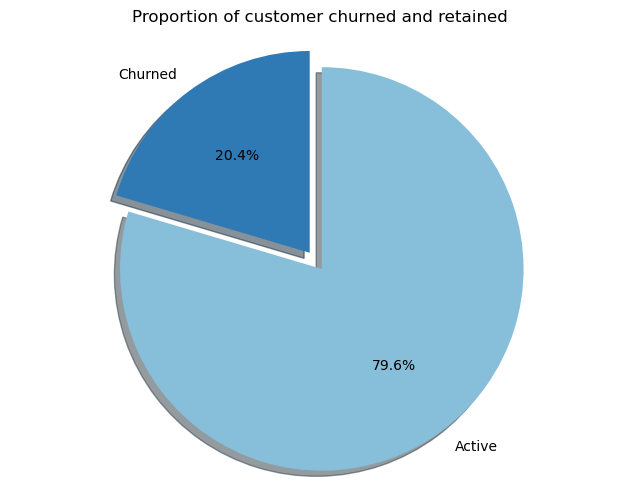

In [10]:
# 20.4% of users churned
labels = 'Churned', 'Active'
sizes = [df.Churn_flag[df['Churn_flag']==1].count(), df.Churn_flag[df['Churn_flag']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained")
plt.show()

In [11]:
categorical_vars = ['Geography', 'Gender', 'Age_Band', 'CreditCardholder', 'CustomerWithLoan', 'Tenure_Band', 'Churn_flag']

continuous_vars = list(set(df.columns.tolist()) - set(categorical_vars))
categorical_vars.remove('Churn_flag')

In [12]:
# Check for existence of outliers in numerical columns
lst = list(df[continuous_vars])
length = len(df)

for col in continuous_vars:

    sorted_col = df[col].sort_values(ascending = True)
    q1, q3= np.percentile(sorted_col,[25,75])
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr) 
    upper_bound = q3 +(1.5 * iqr)

    lower_limit = len(sorted_col.loc[lambda x: x<lower_bound])/len(sorted_col)
    upper_limit = len(sorted_col.loc[lambda x: x>upper_bound])/len(sorted_col)
    
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col, len((np.where((df[col] > upper_bound) |

                                                                                        (df[col] < lower_bound))[0])), len((np.where((df[col] > upper_bound) |
                                                                                                                               (df[col] < lower_bound))[0]))*100/length))
    print('Percent of outliers low:', len(np.where(df[col] < lower_bound)[0]) /length)
    print('Percent of outliers high:', len(np.where(df[col] > upper_bound)[0]) /length)
    print(90 * '-')

Number of outliers and percentage of it in BalanceEuros : 0 and %0.0
Percent of outliers low: 0.0
Percent of outliers high: 0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in avg_savings_per_prod : 0 and %0.0
Percent of outliers low: 0.0
Percent of outliers high: 0.0
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in Digital_TRX_ratio : 74 and %0.7410374524334068
Percent of outliers low: 0.004105748047266173
Percent of outliers high: 0.003304626477067895
------------------------------------------------------------------------------------------
Number of outliers and percentage of it in income_balance_ratio : 84 and %0.8411776487081914
Percent of outliers low: 0.0
Percent of outliers high: 0.008411776487081914
------------------------------------------------------------------------------------------
Number of outliers a

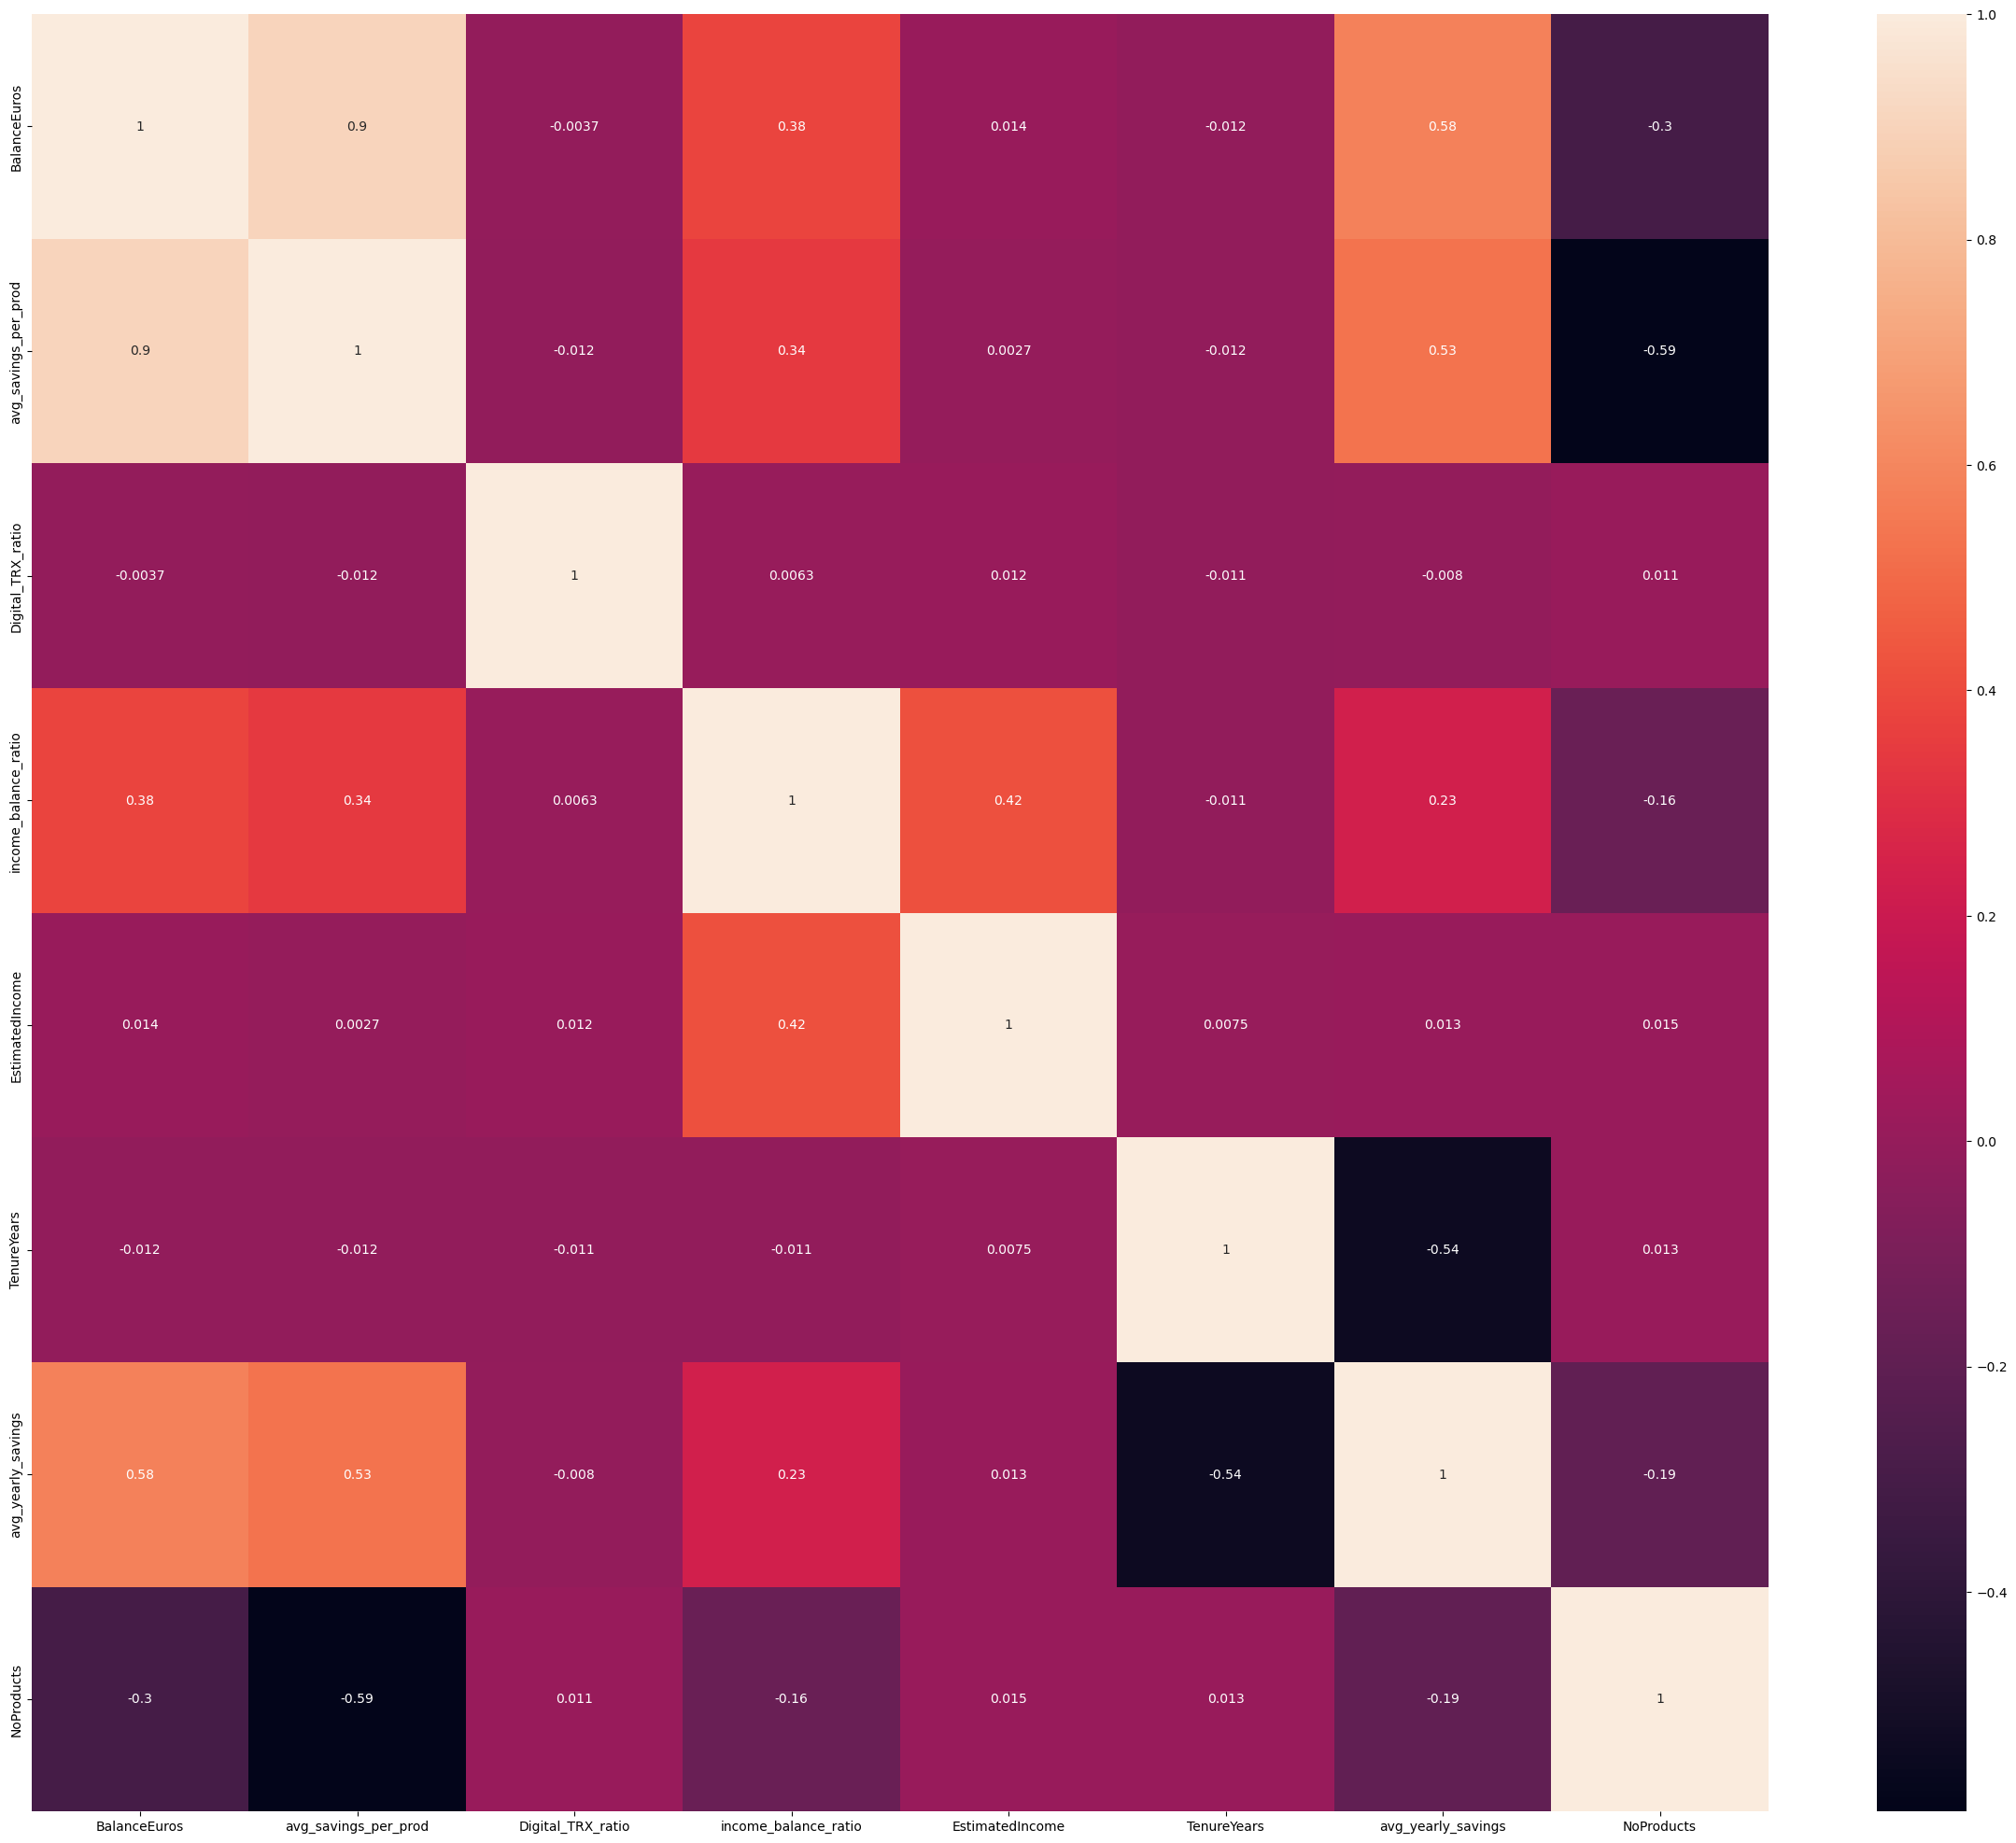

In [13]:
# There seems to be no large correllation among numerical features except balance and balance per product

plt.figure(figsize = (30, 25))
sns.heatmap(df[continuous_vars].corr(), annot = True)
plt.show()

In [14]:
# Will drop balance per product from now on
df = df.drop(columns=['avg_savings_per_prod'])
continuous_vars.remove('avg_savings_per_prod')

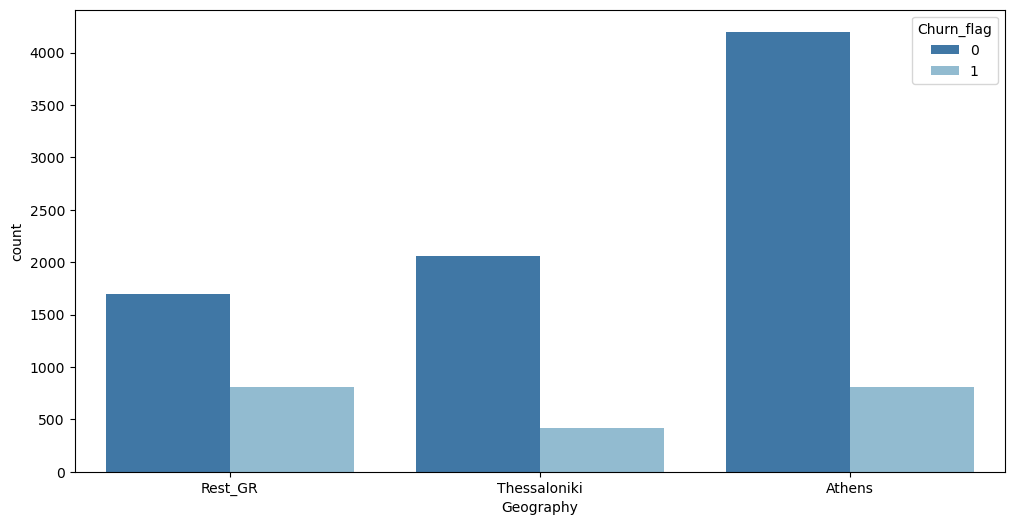

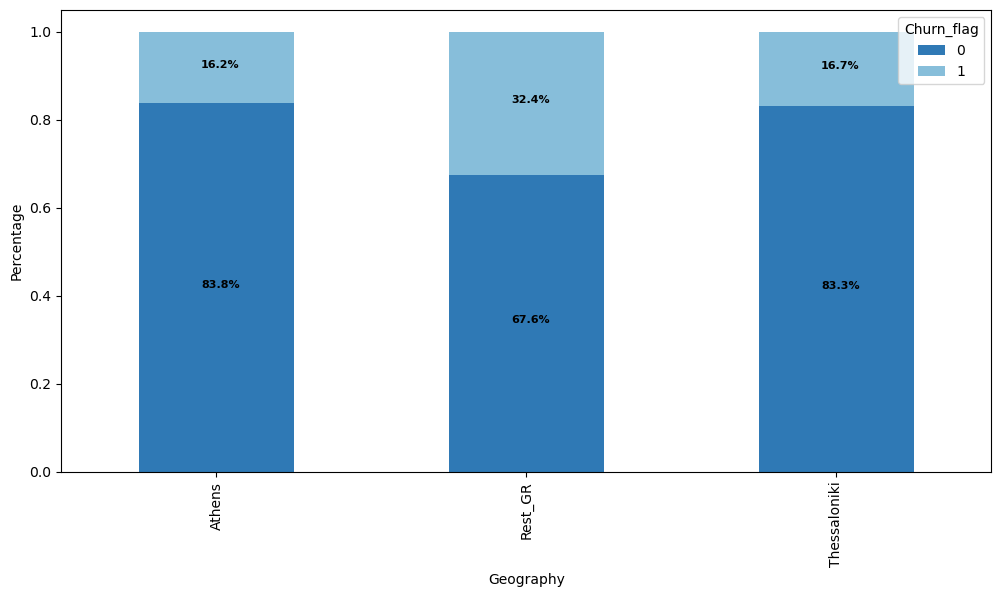

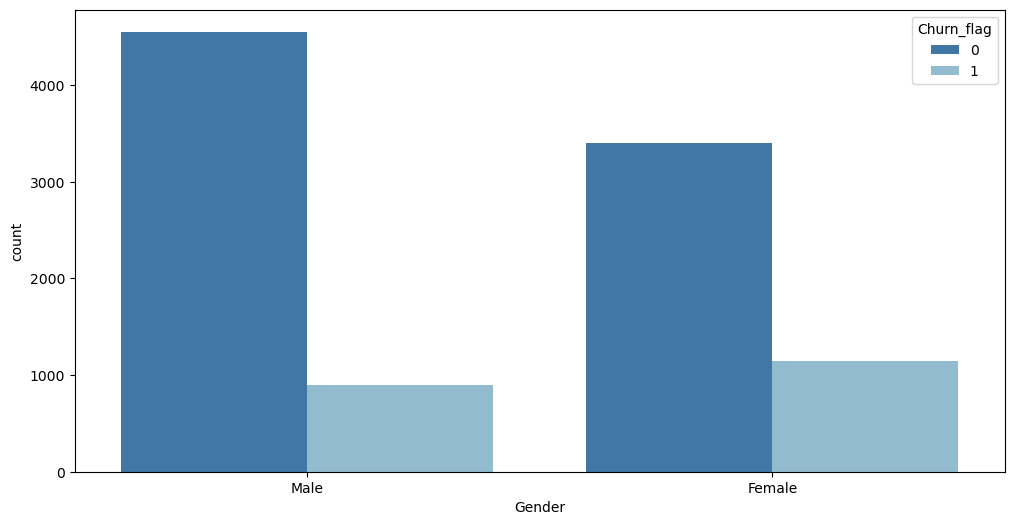

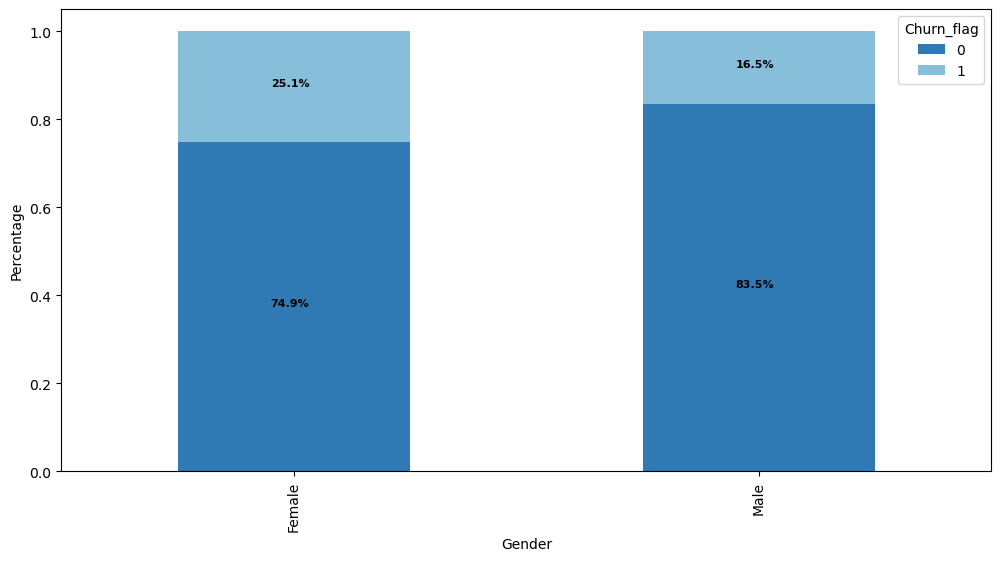

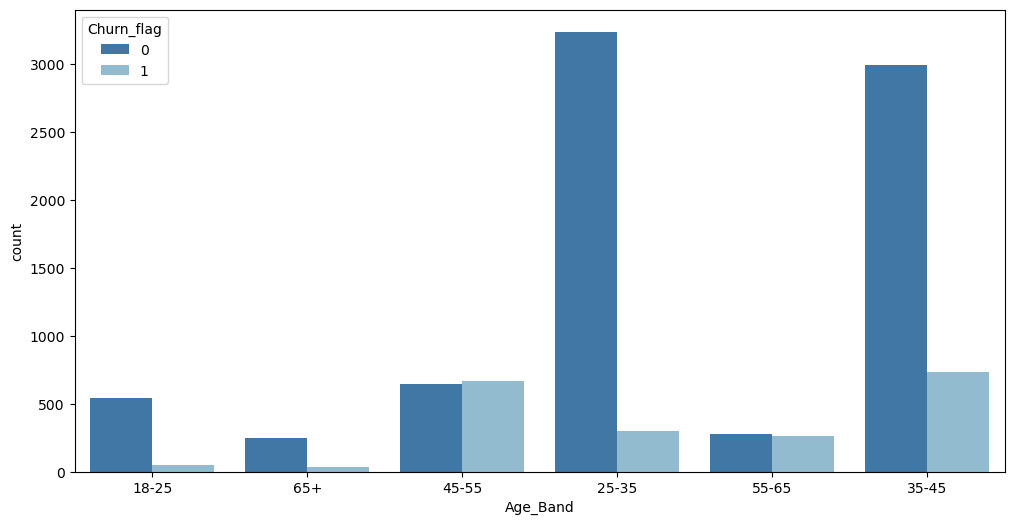

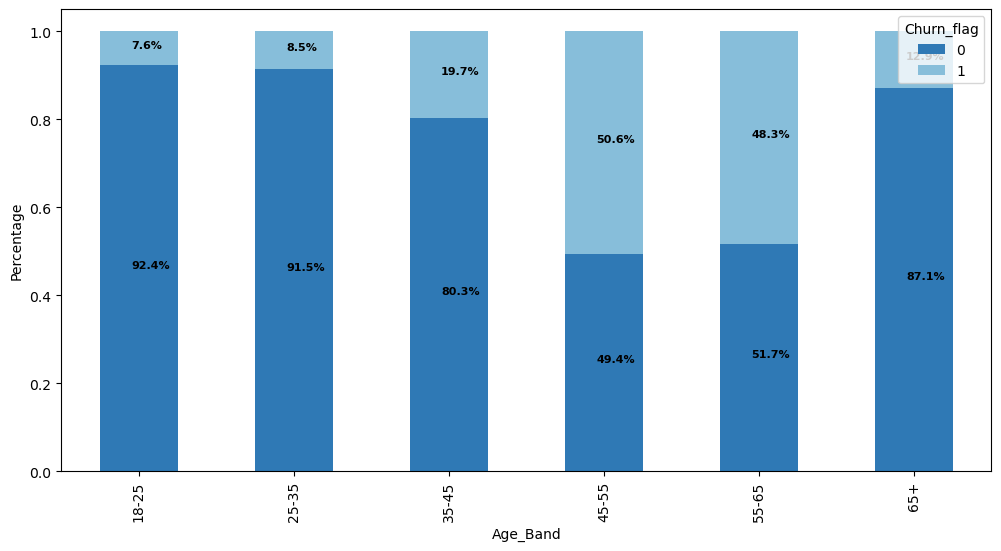

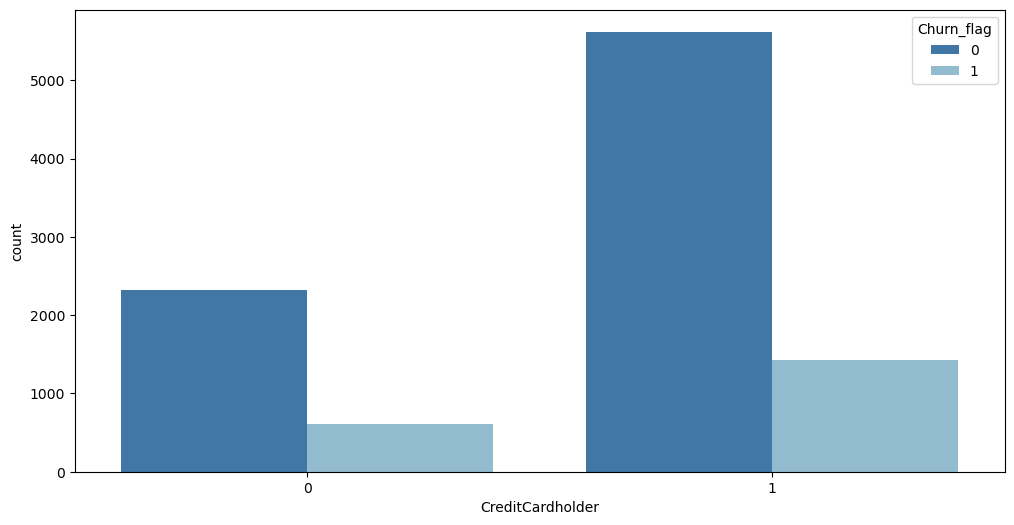

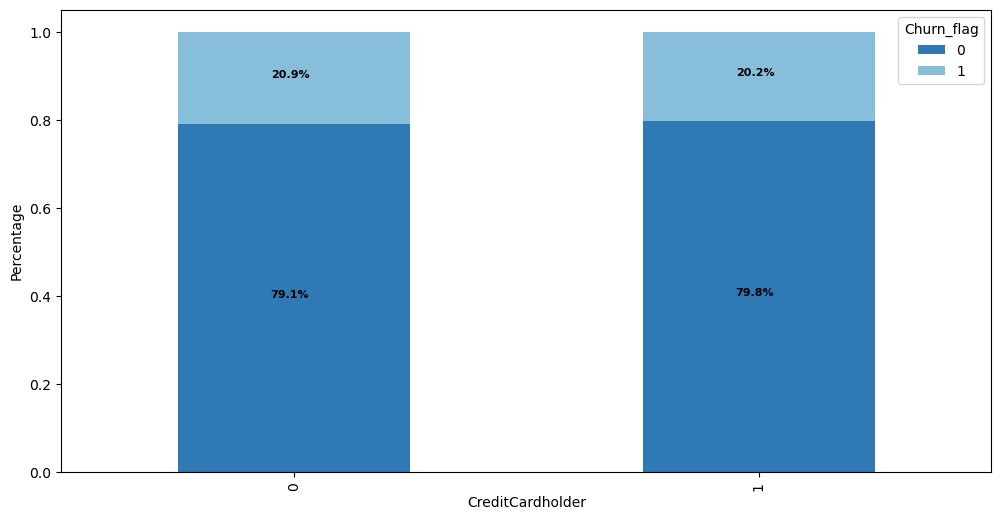

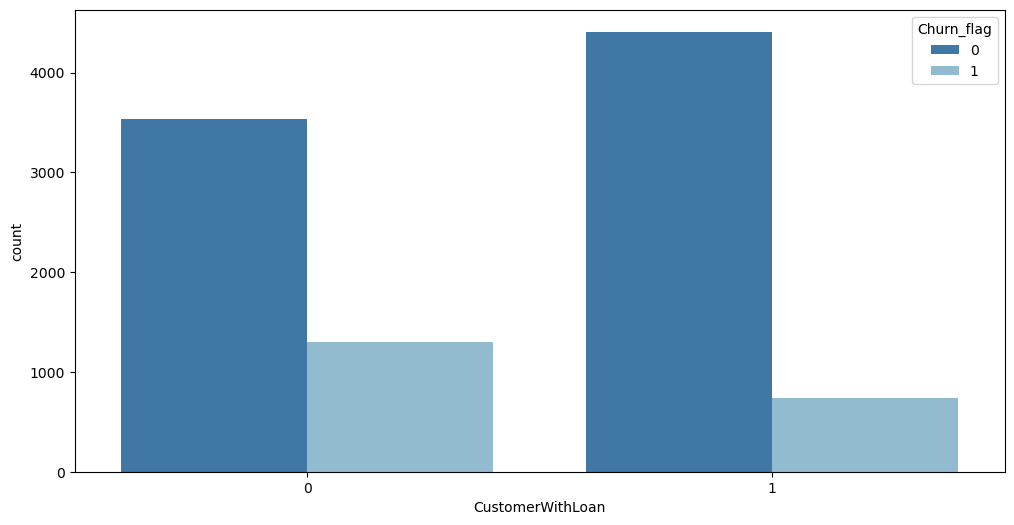

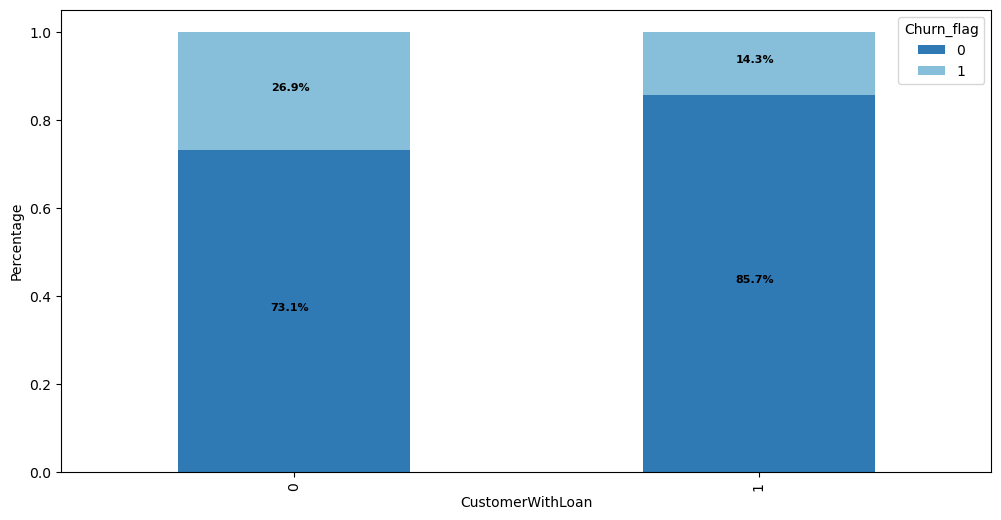

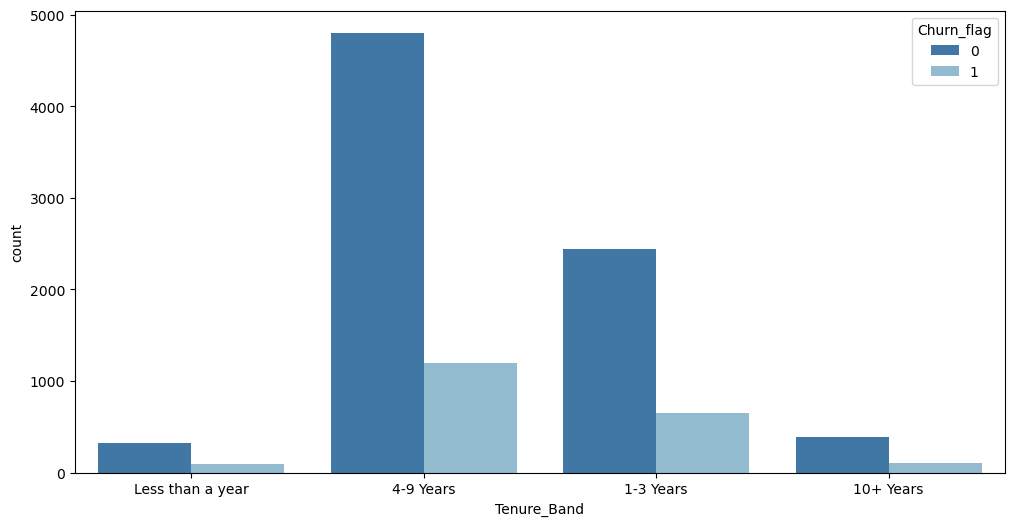

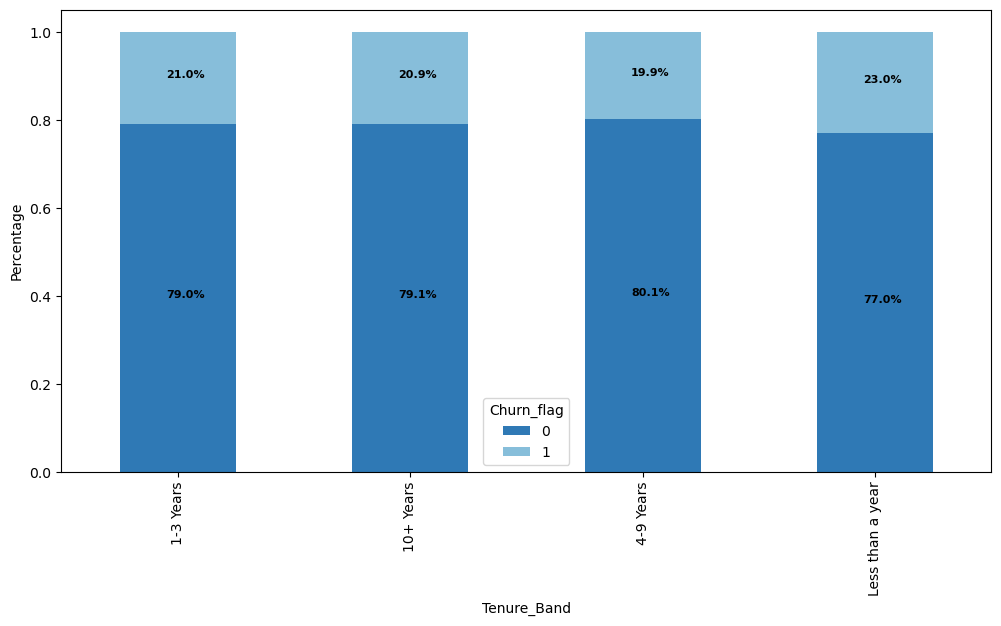

In [15]:
for col in categorical_vars:

    plt.figure(figsize=(12,6))
    sns.countplot(x=col, hue = 'Churn_flag', data=df)

    cross_tab_prop = pd.crosstab(index=df[col],
                                 columns=df['Churn_flag'],
                                 normalize="index")

    cross_tab = pd.crosstab(index=df[col],
                            columns=df['Churn_flag'])

    cross_tab_prop.plot(kind='bar', stacked=True, figsize=(12,6))

    plt.xlabel(col)
    plt.ylabel("Percentage")

    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, y_loc) in zip(cross_tab_prop.loc[x],cross_tab_prop.loc[x].cumsum()):
            plt.text(x=n - 0.05, y=(y_loc - proportion) + (proportion / 2), s=f'{np.round(proportion * 100, 1)}%', color="black", fontsize=8, fontweight="bold")


<Figure size 1800x600 with 0 Axes>

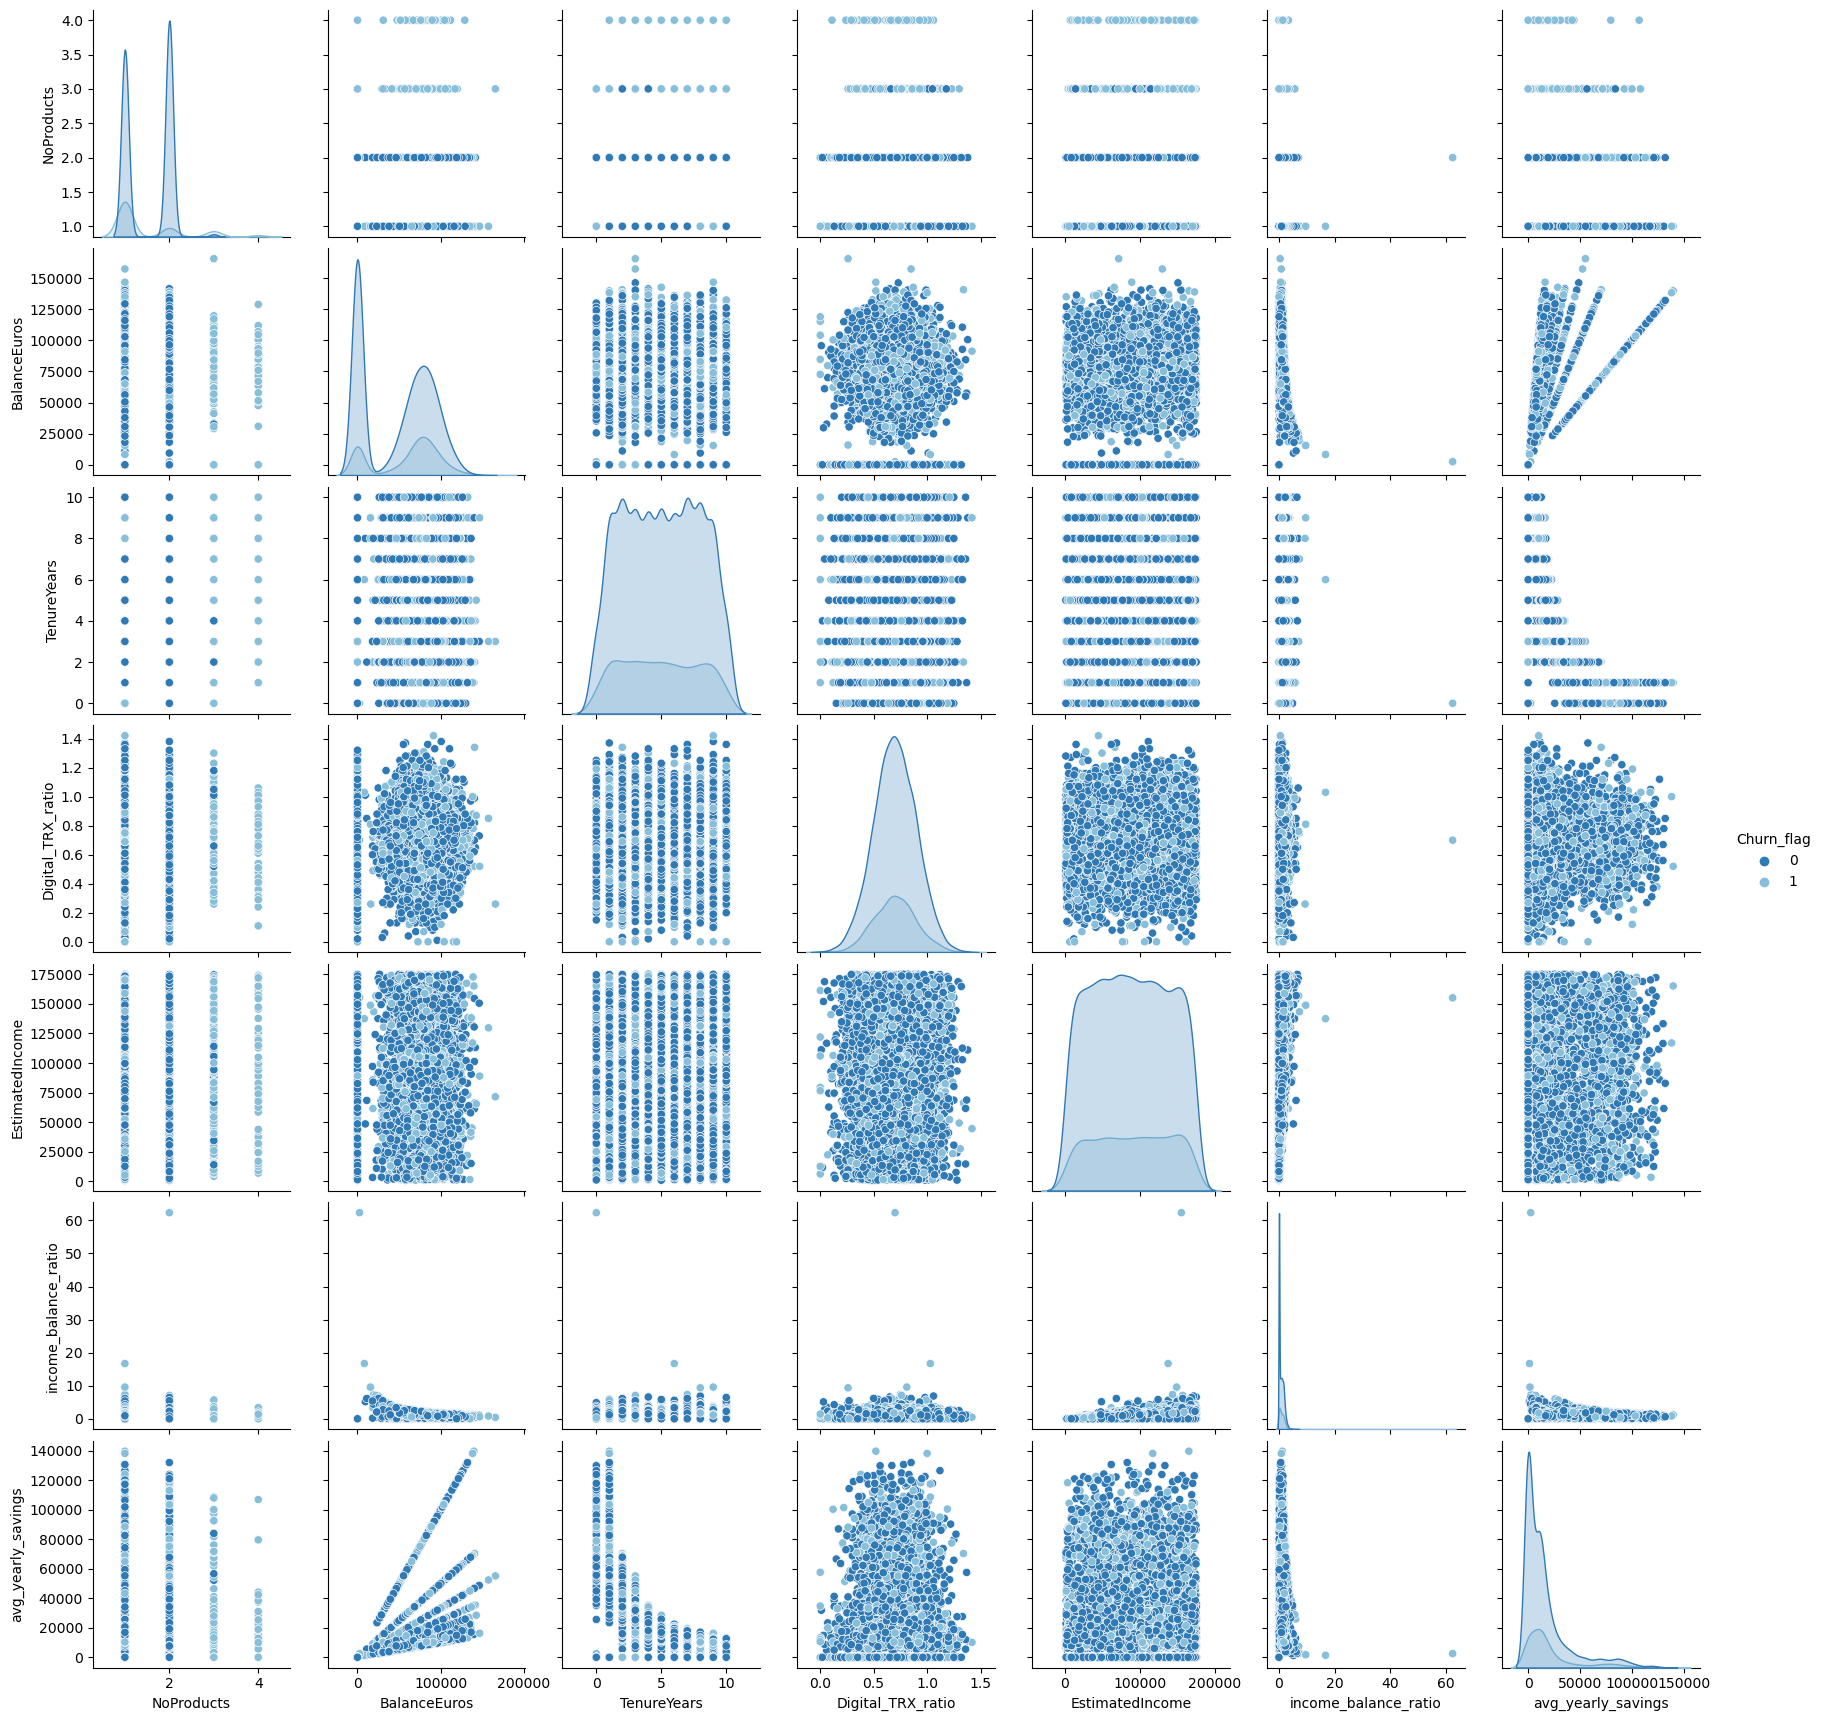

In [16]:
plt.figure(figsize=(18,6))
scatter_vars = df[['NoProducts', 'BalanceEuros', 'TenureYears',
                   'Digital_TRX_ratio', 'EstimatedIncome', 
                   'income_balance_ratio', 'avg_yearly_savings',
                   'Churn_flag']]

sns.pairplot(scatter_vars, hue='Churn_flag')
plt.show()

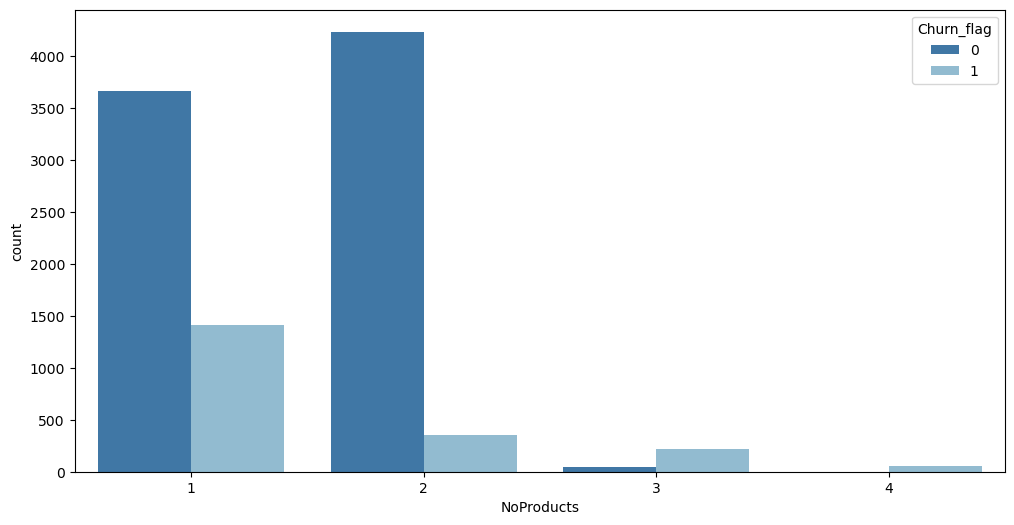

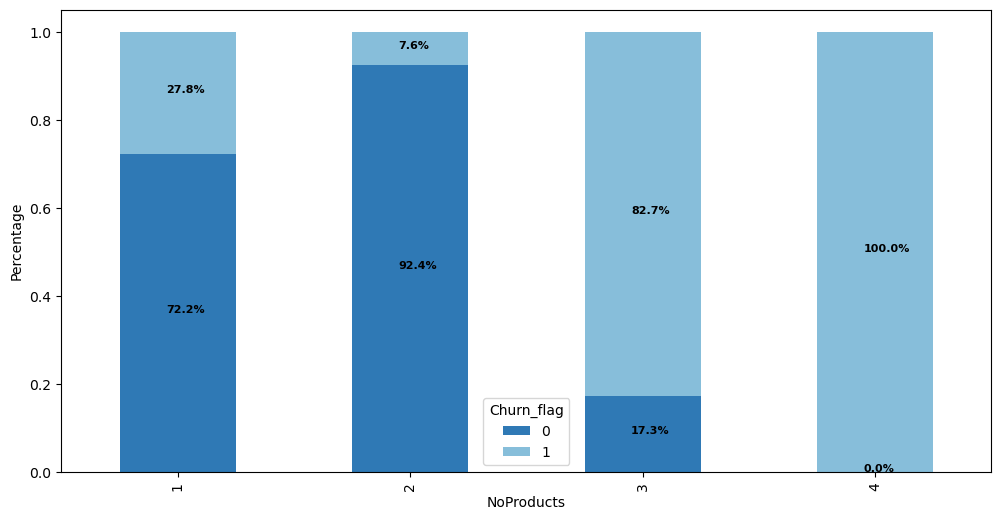

In [17]:
for col in ['NoProducts']:

    plt.figure(figsize=(12,6))
    sns.countplot(x=col, hue = 'Churn_flag', data=df)

    cross_tab_prop = pd.crosstab(index=df[col],
                                 columns=df['Churn_flag'],
                                 normalize="index")

    cross_tab = pd.crosstab(index=df[col],
                            columns=df['Churn_flag'])

    cross_tab_prop.plot(kind='bar', stacked=True, figsize=(12,6))

    plt.xlabel(col)
    plt.ylabel("Percentage")

    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, y_loc) in zip(cross_tab_prop.loc[x],cross_tab_prop.loc[x].cumsum()):
            plt.text(x=n - 0.05, y=(y_loc - proportion) + (proportion / 2), s=f'{np.round(proportion * 100, 1)}%', color="black", fontsize=8, fontweight="bold")


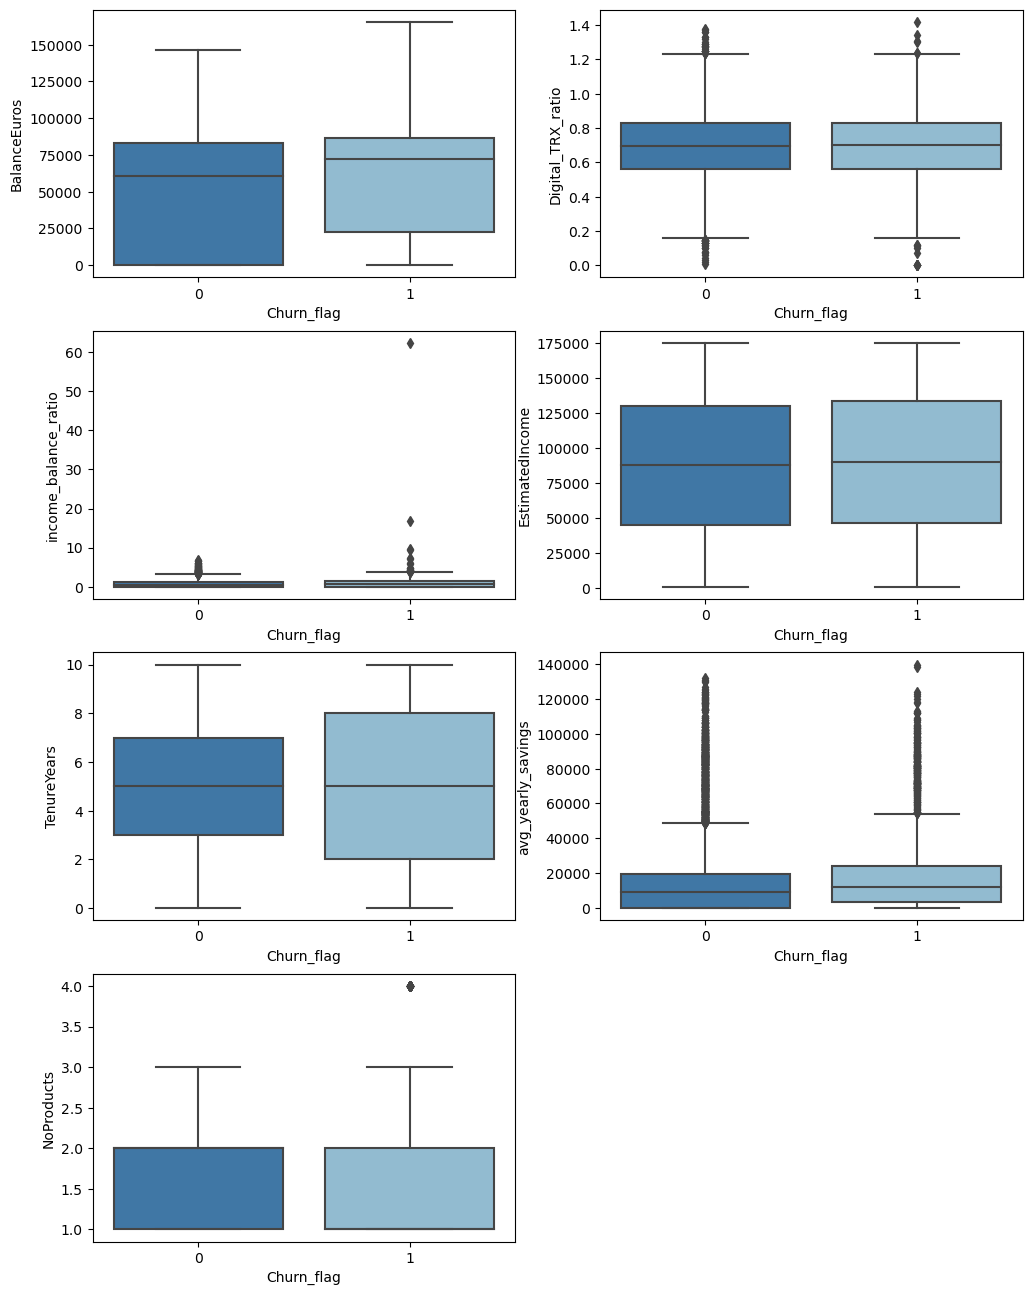

In [18]:
i=1
plt.figure(figsize=(12,16))

for num in continuous_vars:
    plt.subplot(4,2,i)
    sns.boxplot(y=num, x='Churn_flag', data=df)
    
    i+=1

<AxesSubplot:xlabel='BalanceEuros', ylabel='Density'>

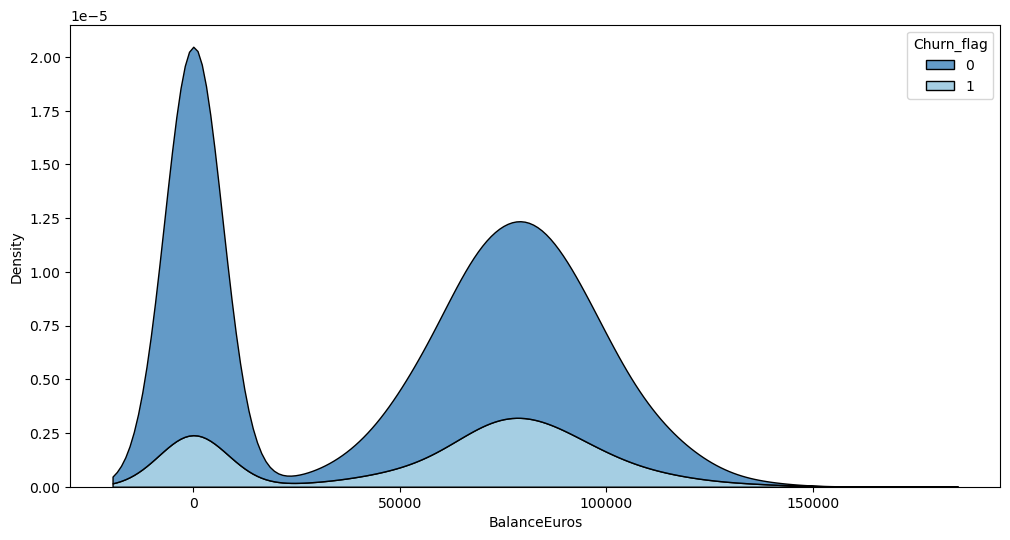

In [19]:
plt.figure(figsize=(12,6))
sns.kdeplot(data=df, x='BalanceEuros', hue='Churn_flag', multiple='stack')

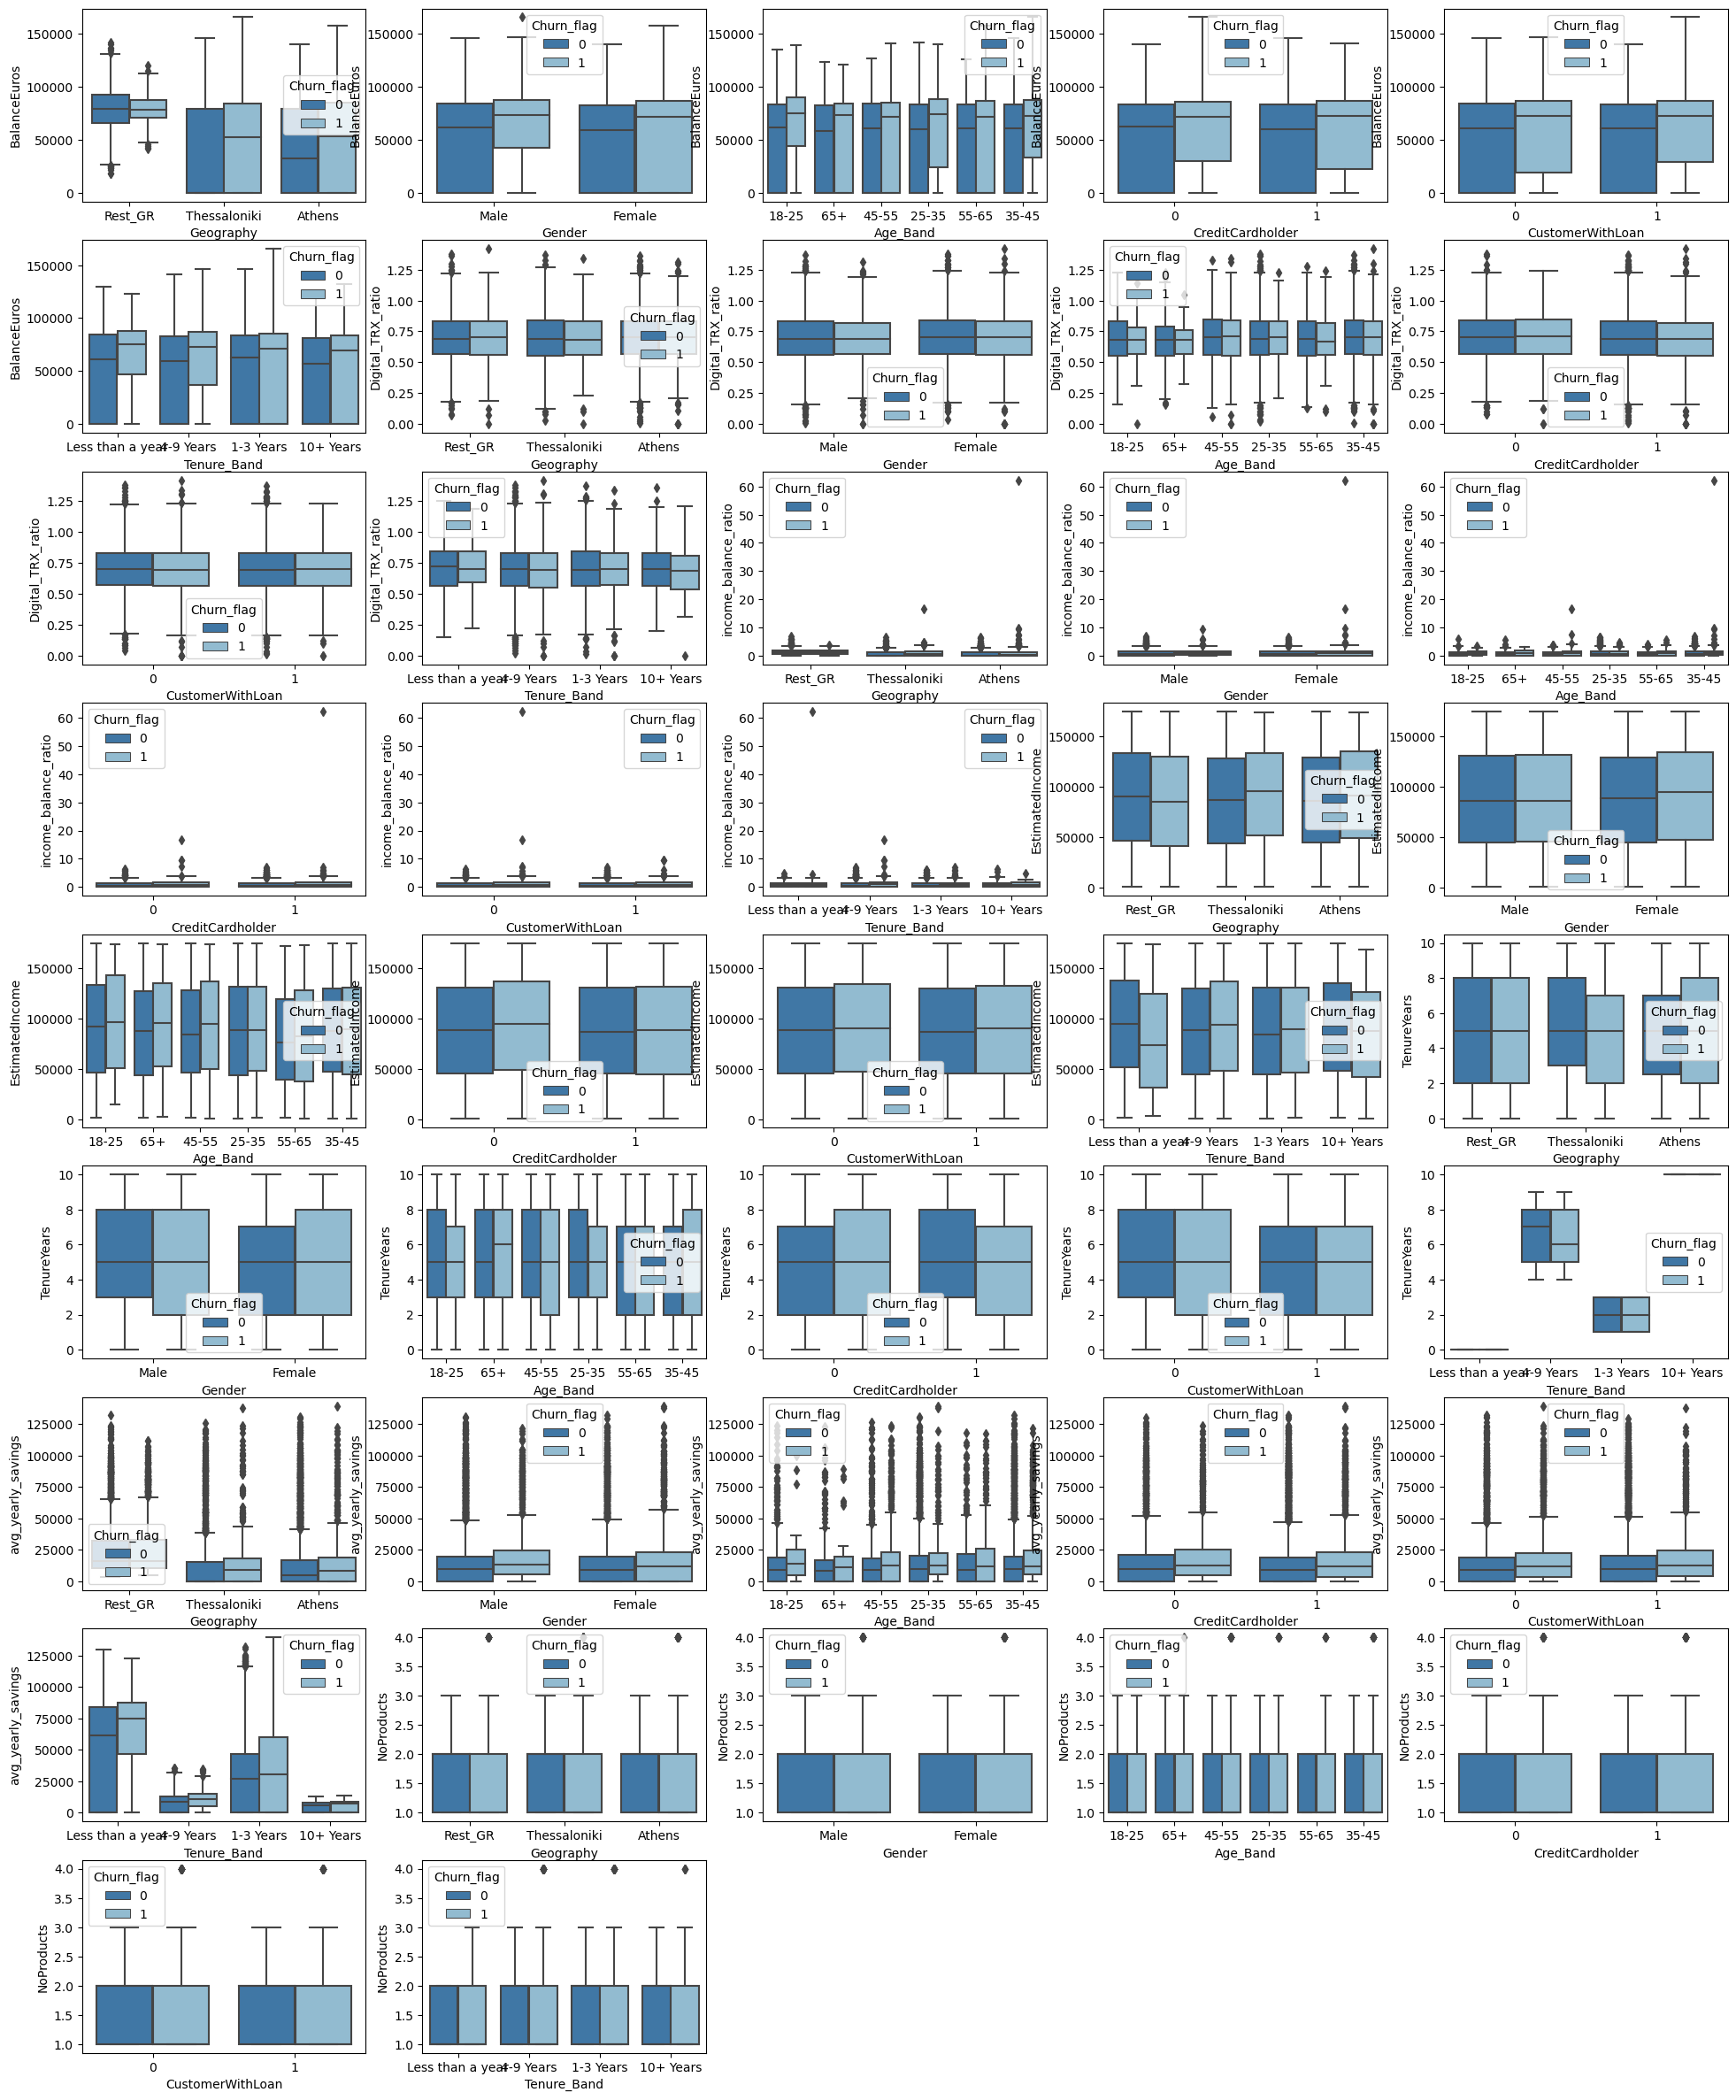

In [20]:
i=1

plt.figure(figsize=(24,30))

for num in continuous_vars:
    for cat in categorical_vars:
        
        plt.subplot(9,5,i)
        sns.boxplot(x=cat, y=num, hue='Churn_flag', data=df)

        i+=1

In [21]:
df = df[['Tenure_Band', 'Age_Band', 'BalanceEuros',
         'CustomerWithLoan','Geography', 'Gender', 
         'avg_yearly_savings', 'NoProducts', 'Churn_flag']]

In [22]:
df_encoded = pd.get_dummies(df, columns = ['Geography', 'Gender', 'Age_Band', 'Tenure_Band'])

# X -> Predictors, y -> Target 
y = df_encoded['Churn_flag']
features = list(df_encoded.columns)
features = [e for e in features if e not in ('Churn_flag')]
X = df_encoded[features]

X = X.reindex(sorted(X.columns), axis=1)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)   

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression

In [23]:
# instantiate the classifier 
lrc = LogisticRegression(max_iter=1000, random_state=42)

# fit the model
lrc.fit(X_train_scaled, y_train)

# Predict the Test set results
y_pred_lr = lrc.predict(X_test_scaled)

print('\nOverall Classification Accuracy:', round(100*accuracy_score(y_test, y_pred_lr), 2), '\n\n')
print('Further Metrics\n\n', classification_report(y_test, y_pred_lr))


Overall Classification Accuracy: 82.68 


Further Metrics

               precision    recall  f1-score   support

           0       0.85      0.96      0.90      1597
           1       0.64      0.31      0.42       401

    accuracy                           0.83      1998
   macro avg       0.74      0.63      0.66      1998
weighted avg       0.81      0.83      0.80      1998



# SVM

In [24]:
params = {"C": [.01, .1, 1, 5, 10, 100],
        "gamma": [0, .01, .1, 1, 5, 10, 100],
        "kernel": ['rbf', 'poly', 'sigmoid', 'linear'],
        "random_state": [42]}

rs_svm = RandomizedSearchCV(estimator=SVC(),
                         param_distributions=params,
                         scoring = 'recall',
                         n_iter=5,
                         cv = 10,
                         refit = True)

rs_svm.fit(X_train_scaled,y_train)

y_pred_svm = rs_svm.predict(X_test_scaled)

print('\nOverall Classification Accuracy:', round(100*accuracy_score(y_test, y_pred_svm), 2), '\n\n')
print('Further Metrics\n\n', classification_report(y_test, y_pred_svm))


Overall Classification Accuracy: 83.18 


Further Metrics

               precision    recall  f1-score   support

           0       0.86      0.95      0.90      1597
           1       0.64      0.37      0.47       401

    accuracy                           0.83      1998
   macro avg       0.75      0.66      0.68      1998
weighted avg       0.81      0.83      0.81      1998



# XGBoost

In [25]:
params = { 'max_depth': np.arange(1, 10, 1),
           'subsample': np.arange(0.1, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'min_child_weight': [1, 5, 10],
           'gamma': [0.5, 1, 1.5, 2, 5],
           'n_estimators': [100, 250, 500],
           'learning_rate':[0.001, 0.01, 0.1]}    

classifier  = xgb.XGBClassifier(random_state=42, n_jobs=4, verbosity=0, early_stopping=10)

rs_xgb = RandomizedSearchCV(estimator=classifier,
                         param_distributions=params,
                         scoring = 'recall',
                         n_iter=5,
                         cv = 10,
                         refit = True)

rs_xgb.fit(X_train, y_train)
y_pred_xgb = rs_xgb.predict(X_test)
y_pred_xgb_proba = rs_xgb.predict_proba(X_test)

print('\nOverall Classification Accuracy:', round(100*accuracy_score(y_test, y_pred_xgb), 2), '\n\n')
print('Further Metrics\n\n', classification_report(y_test, y_pred_xgb))


Overall Classification Accuracy: 85.24 


Further Metrics

               precision    recall  f1-score   support

           0       0.87      0.96      0.91      1597
           1       0.74      0.40      0.52       401

    accuracy                           0.85      1998
   macro avg       0.80      0.68      0.72      1998
weighted avg       0.84      0.85      0.83      1998



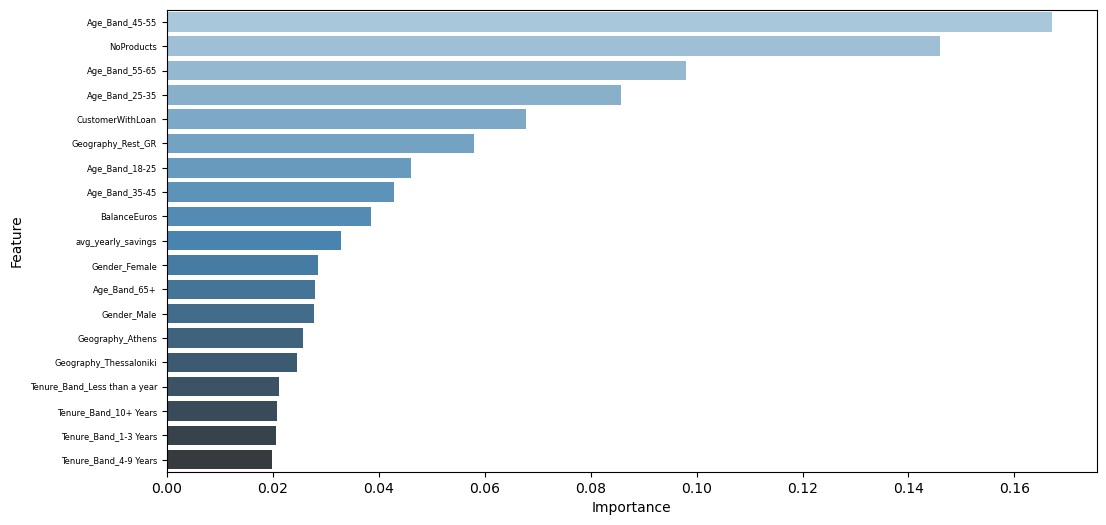

In [31]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rs_xgb.best_estimator_.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')

feat_imp_plot = importances.iloc[:60][:]
plt.figure(figsize = (12,6))
ax = sns.barplot(x=feat_imp_plot['Importance'], y=feat_imp_plot.index, data=feat_imp_plot, palette="Blues_d")
_, labels = plt.yticks()
# set the label size
ax.set_yticklabels(labels, size = 6)
plt.show()

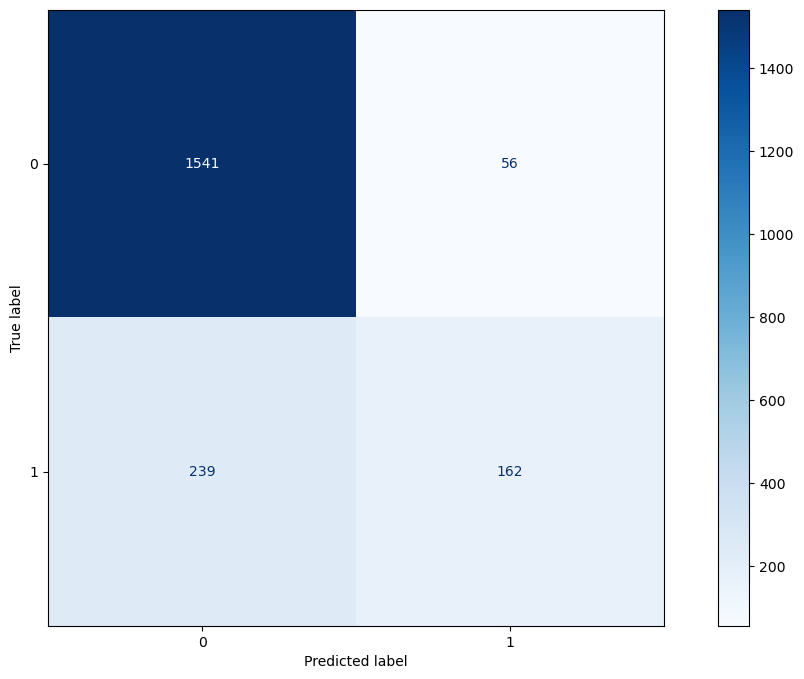

In [27]:
plt.rcParams["figure.figsize"] = (14,8)

cm = confusion_matrix(y_test, y_pred_xgb)

classes = [0, 1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

disp.plot(cmap=plt.cm.Blues)

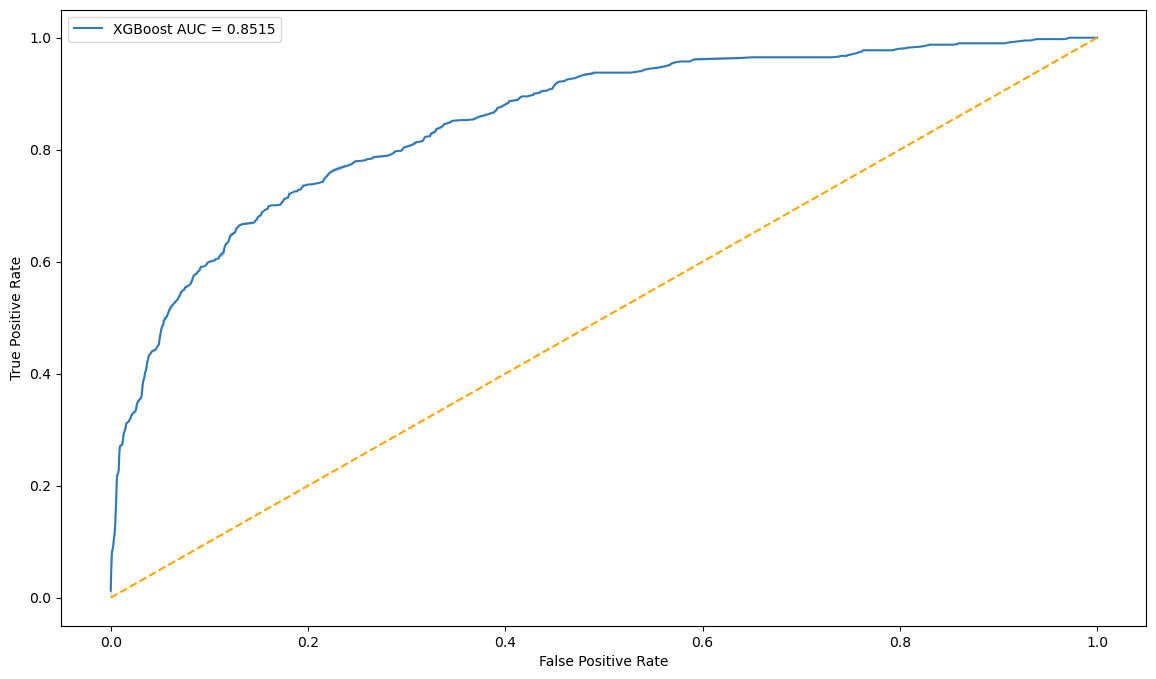

In [28]:
plt.rcParams["figure.figsize"] = (14,8)
fpr, tpr, _ = roc_curve(y_test, y_pred_xgb_proba[:,1])
roc_auc = round(auc(fpr, tpr), 4)
sns.lineplot(x = fpr, y = tpr, label=f'XGBoost AUC = {roc_auc}')
sns.lineplot(x = [0, 1], y = [0, 1], color = 'orange', linestyle="dashed")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

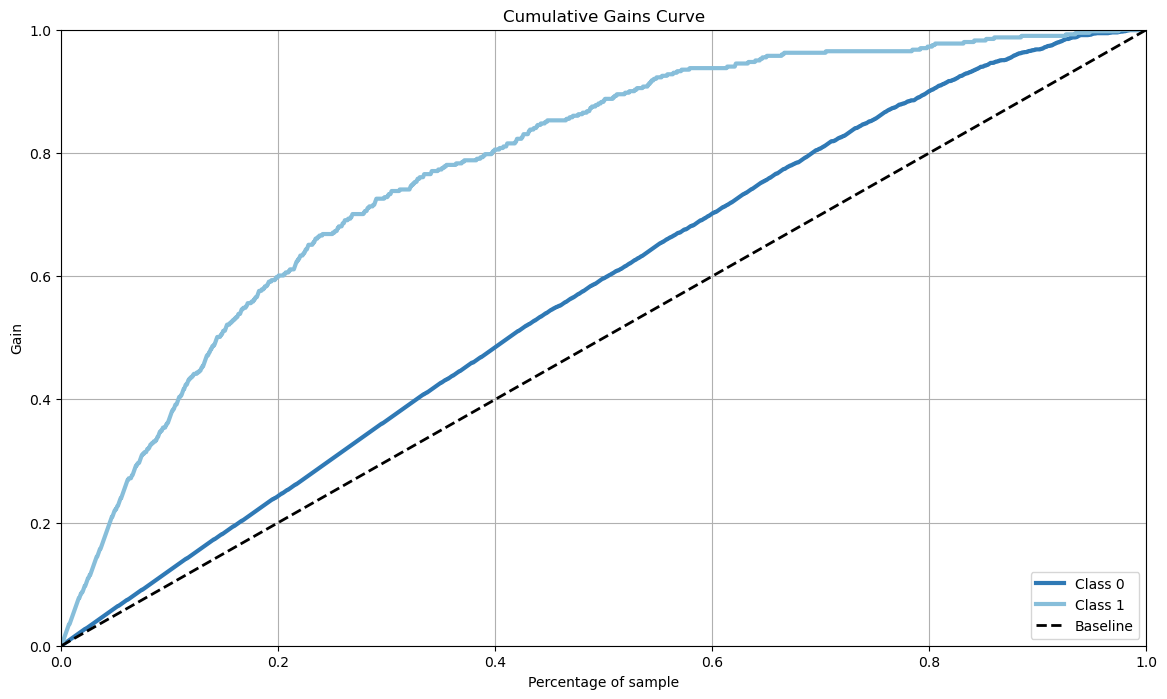

In [29]:
# Plot Gains Chart
plt.rcParams["figure.figsize"] = (14,8)
skplt.metrics.plot_cumulative_gain(y_test, y_pred_xgb_proba)
# plt.ylim(([0,25]))
plt.xlim(([0,1.0]))
plt.show()

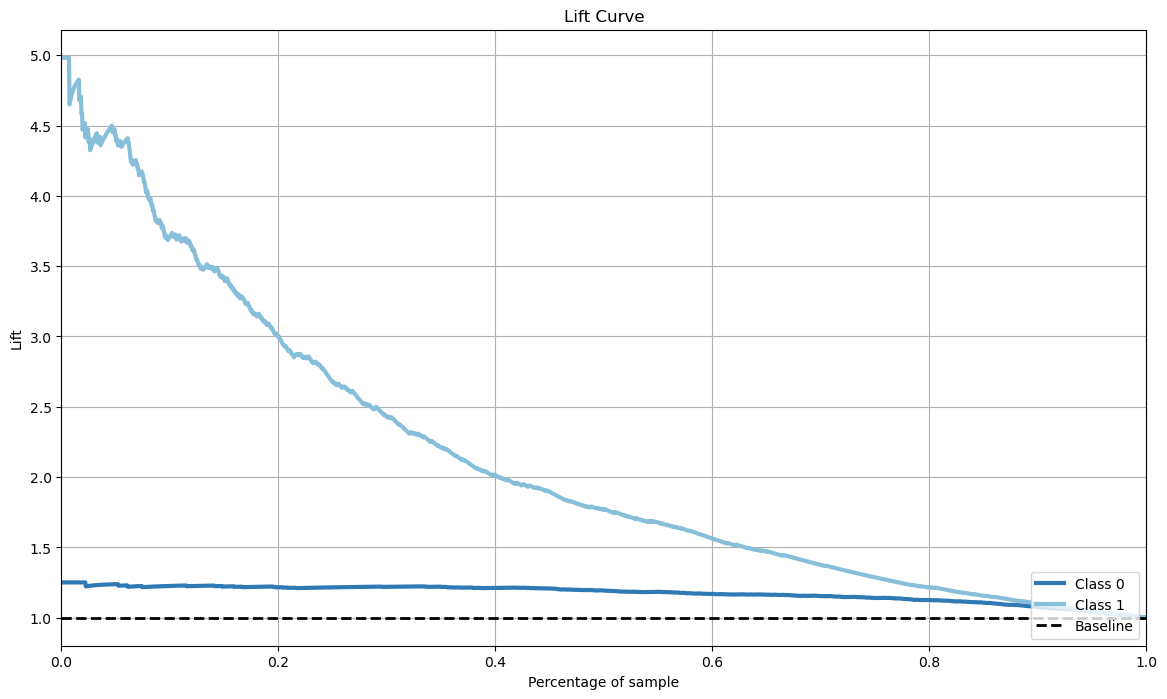

In [30]:
# Plot Lift Chart
plt.rcParams["figure.figsize"] = (14,8)
skplt.metrics.plot_lift_curve(y_test, y_pred_xgb_proba)
# plt.ylim(([0,25]))
plt.xlim(([0,1.0]))
plt.show()